In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
import seaborn as sns

## Import data

In [2]:
t1_son2 = pd.read_csv('trajectories_SPa1869_2024-11-12.csv', index_col=0)
t2_son2 = pd.read_csv('trajectories_SPa1869_2025-01-15.csv', index_col=0)
t1_wt = pd.read_csv('trajectories_WT_2024-10-14.csv', index_col=0)
t2_wt = pd.read_csv('trajectories_WT_2024-11-12.csv', index_col=0)
t_df = pd.read_csv('trajectories_ΔfleN_2024-11-12.csv', index_col=0)

## Check duration for each trajectory

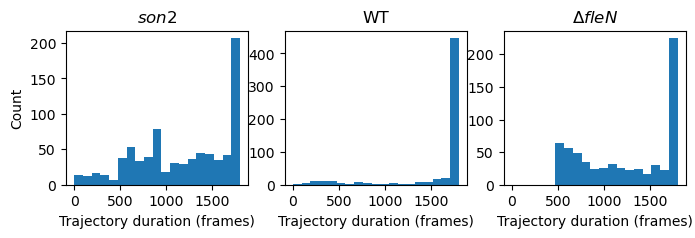

In [25]:
fig,ax = plt.subplots(1,3, figsize=(8,2))

gb_son2 = t1_son2.groupby('particle')['frame'].agg(len)
gb2_son2 = t2_son2.groupby('particle')['frame'].agg(len)
ax[0].hist(np.concatenate((gb_son2.values, gb2_son2.values)), bins=np.linspace(0,1800,20));
ax[0].set_title('$son2$')
ax[0].set_ylabel('Count');
ax[0].set_xlabel('Trajectory duration (frames)');

gb_wt = t1_wt.groupby('particle')['frame'].agg(len)
gb2_wt = t2_wt.groupby('particle')['frame'].agg(len)
ax[1].hist(np.concatenate((gb_wt.values, gb2_wt.values)), bins=np.linspace(0,1800,20));
ax[1].set_title('WT')
ax[1].set_xlabel('Trajectory duration (frames)');

gb_df = t_df.groupby('particle')['frame'].agg(len)
ax[2].hist(gb_df.values, bins=np.linspace(0,1800,20));
ax[2].set_title('$\Delta fleN$')
ax[2].set_xlabel('Trajectory duration (frames)');
plt.savefig('Trajectory_durations.png');

## Calculate path lengths for each trajectory (consistency check against integrated smoothing)

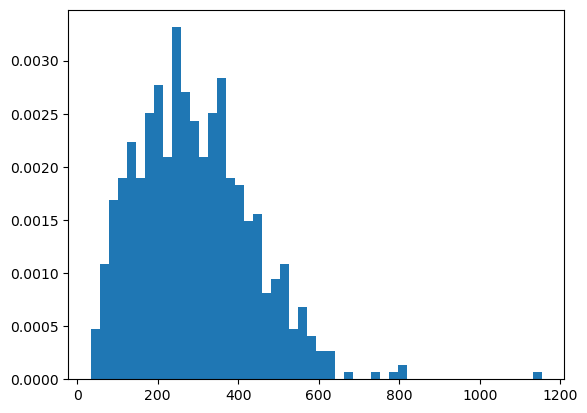

In [4]:
arclengths_son2 = []
for p,df_slice in t1_son2.groupby('particle'):
    df_slice = df_slice[df_slice.v > 1]
    if len(df_slice) < 5:
        continue
    vxs = savgol_filter(df_slice.x.values, 5, 1, deriv=1)
    vys = savgol_filter(df_slice.y.values, 5, 1, deriv=1)
    vzs = savgol_filter(df_slice.z.values, 5, 1, deriv=1)
    arclengths_son2.append(np.sum(np.sqrt(vxs**2 + vys**2 + vzs**2))*0.559)
plt.hist(arclengths_son2, bins=50, density=True);

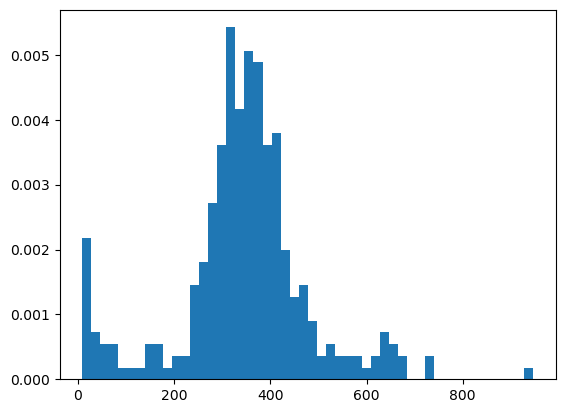

In [5]:
arclengths_wt = []
for p,df_slice in t2_wt.groupby('particle'):
    df_slice = df_slice[df_slice.v > 1]
    if len(df_slice) < 5:
        continue
    vxs = savgol_filter(df_slice.x.values, 5, 1, deriv=1)
    vys = savgol_filter(df_slice.y.values, 5, 1, deriv=1)
    vzs = savgol_filter(df_slice.z.values, 5, 1, deriv=1)
    arclengths_wt.append(np.sum(np.sqrt(vxs**2 + vys**2 + vzs**2))*0.559)
plt.hist(arclengths_wt, bins=50, density=True);

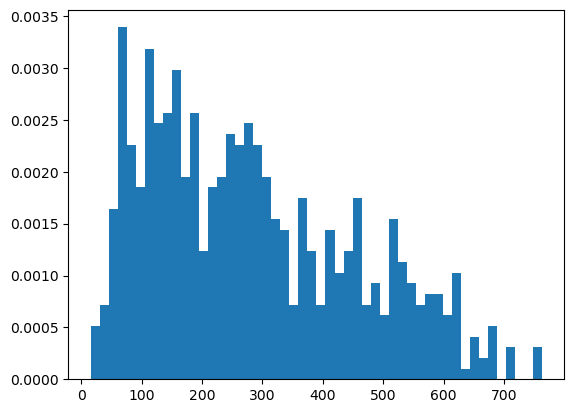

In [6]:
arclengths_df = []
for p,df_slice in t_df.groupby('particle'):
    df_slice = df_slice[df_slice.v > 1]
    if len(df_slice) < 5:
        continue
    vxs = savgol_filter(df_slice.x.values, 5, 1, deriv=1)
    vys = savgol_filter(df_slice.y.values, 5, 1, deriv=1)
    vzs = savgol_filter(df_slice.z.values, 5, 1, deriv=1)
    arclengths_df.append(np.sum(np.sqrt(vxs**2 + vys**2 + vzs**2))*0.559)
plt.hist(arclengths_df, bins=50, density=True);

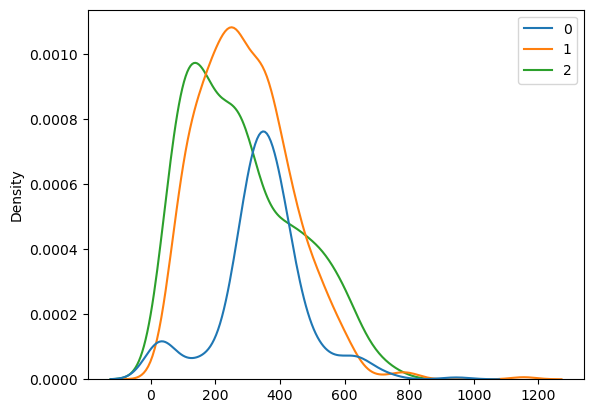

In [7]:
sns.kdeplot([arclengths_wt, arclengths_son2, arclengths_df]);

## Calculate trajectory path lengths with appropriate filtering

In [8]:
def filter_low_velocity_frames(df, velocity_threshold=1.0):
    if 'v' not in df.columns:
        return df  # If no velocity column, do not filter
    initial_count = len(df)
    df_filtered = df[df['v'] >= velocity_threshold].copy()
    filtered_count = initial_count - len(df_filtered)
    #if filtered_count > 0:
    #    print(f"Filtered {filtered_count} low-velocity frames from particle.")
    return df_filtered
#velocity threshold of 1. 1 micrometer per second or bigger 

def calculate_distance_traveled(df):
    coords = df[['x', 'y', 'z']].values
    distances = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    return distances

def apply_savgol_filter(df, window_length=5, polyorder=1):
    df = df.copy().sort_values('frame').reset_index(drop=True)
    for axis in ['x', 'y', 'z']:
        if len(df) >= window_length:
            df[axis] = savgol_filter(df[axis], window_length=window_length, polyorder=polyorder)
    return df
#window you can change it, 5 does not over or undersample

def process_particle(df_particle, smoothing=True, window_length=5, polyorder=1):
    df_particle = filter_low_velocity_frames(df_particle, velocity_threshold=1.0)
    if len(df_particle) < 3:
        return None
    df_particle = df_particle.sort_values('frame').reset_index(drop=True)
    if smoothing and len(df_particle) >= window_length:
        df_particle = apply_savgol_filter(df_particle, window_length, polyorder)
    cell_microns = 0.559
    distances = calculate_distance_traveled(df_particle)
    total_distance = distances.sum()
    dist_in_microns = total_distance * cell_microns
    return dist_in_microns

In [9]:
arclengths_son2 = []
for p,df_slice in t1_son2.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        arclengths_son2.append(res)

In [10]:
arclengths_wt = []
for p,df_slice in t2_wt.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        arclengths_wt.append(res)

In [11]:
arclengths_df = []
for p,df_slice in t_df.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        arclengths_df.append(res)

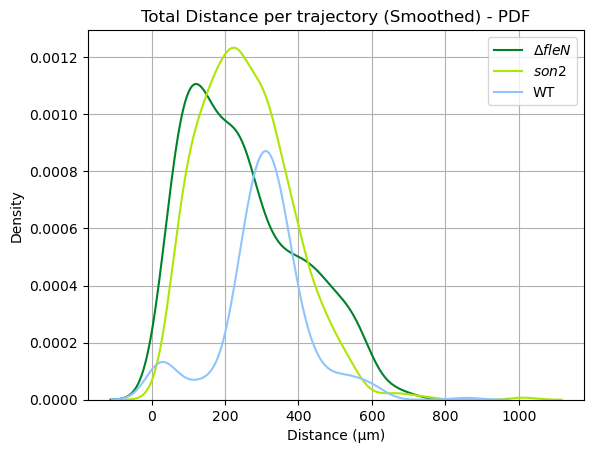

In [12]:
from matplotlib.lines import Line2D
fig,ax = plt.subplots()
colors = {'WT':'#90C4FF', 'son2':'#AFE602', 'dfleN':'#00822C'}
sns.kdeplot([arclengths_wt, arclengths_son2, arclengths_df], palette=[colors['WT'], colors['son2'], colors['dfleN']]);
ax.set_xlabel('Distance (μm)');
plt.grid(True);

# Custom legend
legend_elements = [Line2D([0], [0], color=colors['dfleN'], label='$ΔfleN$'),
                   Line2D([0], [0], color=colors['son2'], label='$son2$'),
                   Line2D([0], [0], color=colors['WT'], label='WT')
                  ]
ax.legend(handles=legend_elements)
plt.title('Total Distance per trajectory (Smoothed) - PDF');
plt.savefig('4E-partialDataset.svg');

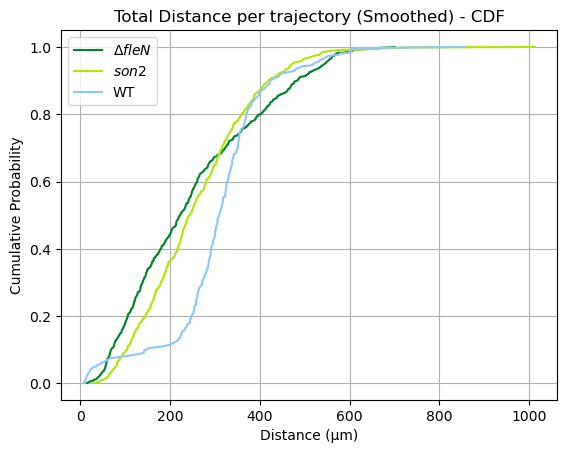

In [13]:
fig,ax = plt.subplots()

sorted_vals_df = np.sort(arclengths_df)
cdf_vals_df = np.arange(1, len(sorted_vals_df)+1) / len(sorted_vals_df)
ax.plot(sorted_vals_df, cdf_vals_df, color=colors['dfleN'], label='$\Delta fleN$')

sorted_vals_son2 = np.sort(arclengths_son2)
cdf_vals_son2 = np.arange(1, len(sorted_vals_son2)+1) / len(sorted_vals_son2)
ax.plot(sorted_vals_son2, cdf_vals_son2, color=colors['son2'], label='$son2$')

sorted_vals_wt = np.sort(arclengths_wt)
cdf_vals_wt = np.arange(1, len(sorted_vals_wt)+1) / len(sorted_vals_wt)
ax.plot(sorted_vals_wt, cdf_vals_wt, color=colors['WT'], label='WT')

ax.set_title(f"Total Distance per trajectory (Smoothed) - CDF")
ax.set_xlabel('Distance (μm)')
ax.set_ylabel("Cumulative Probability")
ax.legend()
ax.grid(True)
plt.savefig('4F-partialDataset.svg');

# Plots with full dataset

In [14]:
arclengths_son2 = []
for p,df_slice in t1_son2.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        arclengths_son2.append(res)
for p,df_slice in t2_son2.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        arclengths_son2.append(res)
        
arclengths_wt = []
for p,df_slice in t1_wt.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        arclengths_wt.append(res)
for p,df_slice in t2_wt.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        arclengths_wt.append(res)
        
arclengths_df = []
for p,df_slice in t_df.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        arclengths_df.append(res)

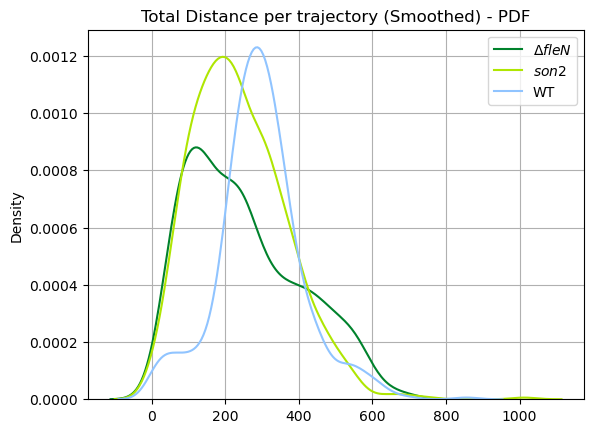

In [15]:
from matplotlib.lines import Line2D
fig,ax = plt.subplots()
sns.kdeplot([arclengths_wt, arclengths_son2, arclengths_df], palette=['#90C4FF', '#AFE602', '#00822C']);
plt.grid(True);

# Custom legend
legend_elements = [Line2D([0], [0], color='#00822C', label='$ΔfleN$'),
                   Line2D([0], [0], color='#AFE602', label='$son2$'),
                   Line2D([0], [0], color='#90C4FF', label='WT')
                  ]
ax.legend(handles=legend_elements)
plt.title('Total Distance per trajectory (Smoothed) - PDF');
plt.savefig('4E-fullDataset.svg');

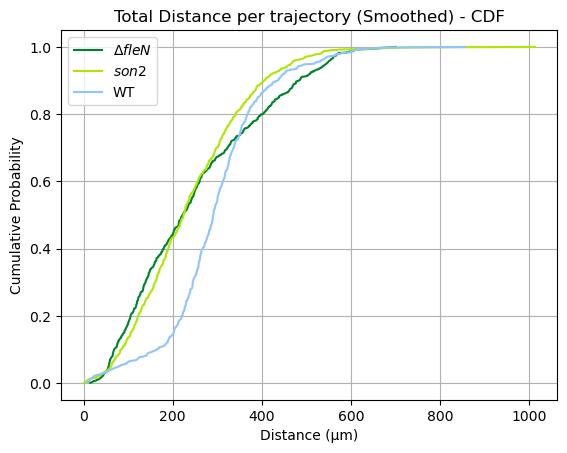

In [16]:
fig,ax = plt.subplots()

sorted_vals_df = np.sort(arclengths_df)
cdf_vals_df = np.arange(1, len(sorted_vals_df)+1) / len(sorted_vals_df)
ax.plot(sorted_vals_df, cdf_vals_df, color=colors['dfleN'], label='$\Delta fleN$')

sorted_vals_son2 = np.sort(arclengths_son2)
cdf_vals_son2 = np.arange(1, len(sorted_vals_son2)+1) / len(sorted_vals_son2)
ax.plot(sorted_vals_son2, cdf_vals_son2, color=colors['son2'], label='$son2$')

sorted_vals_wt = np.sort(arclengths_wt)
cdf_vals_wt = np.arange(1, len(sorted_vals_wt)+1) / len(sorted_vals_wt)
ax.plot(sorted_vals_wt, cdf_vals_wt, color=colors['WT'], label='WT')

ax.set_title(f"Total Distance per trajectory (Smoothed) - CDF")
ax.set_xlabel('Distance (μm)')
ax.set_ylabel("Cumulative Probability")
ax.legend()
ax.grid(True)
plt.savefig('4F-fullDataset.svg');

# Divide by trajectory duration

In [17]:
vs_son2 = []
for p,df_slice in t1_son2.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        dt = len(df_slice)/120
        vs_son2.append(res/dt)
for p,df_slice in t2_son2.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        dt = len(df_slice)/120
        vs_son2.append(res/dt)
        
vs_wt = []
for p,df_slice in t1_wt.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        dt = len(df_slice)/120
        vs_wt.append(res/dt)
for p,df_slice in t2_wt.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        dt = len(df_slice)/120
        vs_wt.append(res/dt)
        
vs_df = []
for p,df_slice in t_df.groupby('particle'):
    res = process_particle(df_slice)
    if res is not None:
        dt = len(df_slice)/120
        vs_df.append(res/dt)

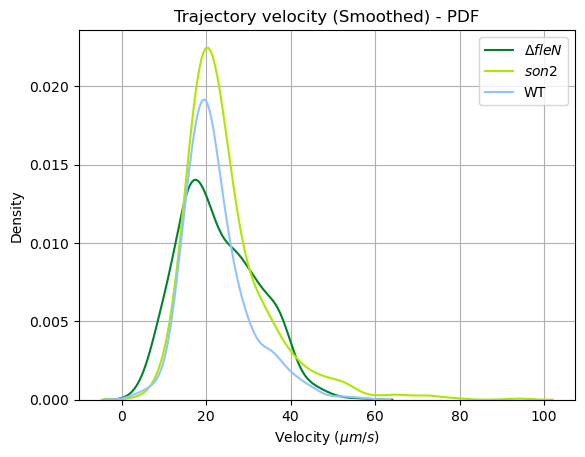

In [18]:
from matplotlib.lines import Line2D
fig,ax = plt.subplots()
sns.kdeplot([vs_wt, vs_son2, vs_df], palette=['#90C4FF', '#AFE602', '#00822C']);
plt.grid(True);

# Custom legend
legend_elements = [Line2D([0], [0], color='#00822C', label='$ΔfleN$'),
                   Line2D([0], [0], color='#AFE602', label='$son2$'),
                   Line2D([0], [0], color='#90C4FF', label='WT')
                  ]
ax.legend(handles=legend_elements)
ax.set_xlabel('Velocity ($\mu m / s$)');
plt.title('Trajectory velocity (Smoothed) - PDF');
plt.savefig('4E_velocity-fullDataset.svg');

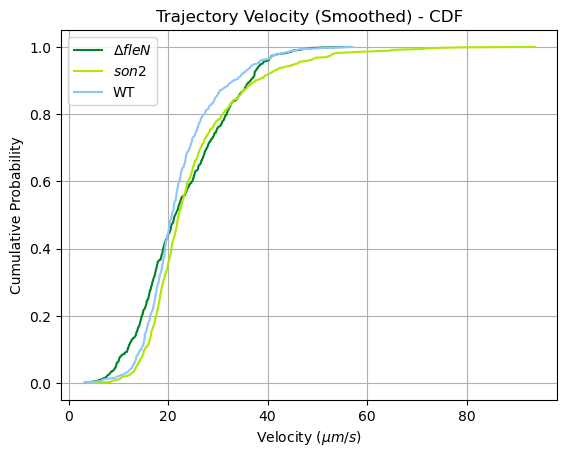

In [19]:
fig,ax = plt.subplots()

sorted_vals_df = np.sort(vs_df)
cdf_vals_df = np.arange(1, len(sorted_vals_df)+1) / len(sorted_vals_df)
ax.plot(sorted_vals_df, cdf_vals_df, color=colors['dfleN'], label='$\Delta fleN$')

sorted_vals_son2 = np.sort(vs_son2)
cdf_vals_son2 = np.arange(1, len(sorted_vals_son2)+1) / len(sorted_vals_son2)
ax.plot(sorted_vals_son2, cdf_vals_son2, color=colors['son2'], label='$son2$')

sorted_vals_wt = np.sort(vs_wt)
cdf_vals_wt = np.arange(1, len(sorted_vals_wt)+1) / len(sorted_vals_wt)
ax.plot(sorted_vals_wt, cdf_vals_wt, color=colors['WT'], label='WT')

ax.set_title(f"Trajectory Velocity (Smoothed) - CDF")
ax.set_xlabel('Velocity ($\mu m / s$)')
ax.set_ylabel("Cumulative Probability")
ax.legend()
ax.grid(True)
plt.savefig('4F_velocity-fullDataset.svg');

## Perform statistical tests on velocity distributions

In [21]:
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp
from math import sqrt

def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std if pooled_std > 0 else np.nan
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

def perform_stat_tests(group1, group2):
    print('Total Distance Statistical Comparison:')
    print("Mann-Whitney U:", mannwhitneyu(group1, group2, alternative='two-sided'))
    print("t-test:", ttest_ind(group1, group2, equal_var=False))
    print("KS test:", ks_2samp(group1, group2))
    print("Cohen's d:", cohens_d(group1, group2))

In [22]:
perform_stat_tests(vs_wt, vs_son2)

Total Distance Statistical Comparison:
Mann-Whitney U: MannwhitneyuResult(statistic=197088.0, pvalue=1.5198777280670433e-05)
t-test: Ttest_indResult(statistic=-5.340896258784504, pvalue=1.0821858398572426e-07)
KS test: KstestResult(statistic=0.10510271122596469, pvalue=0.0011366998236090945, statistic_location=20.1948873157128, statistic_sign=1)
Cohen's d: -0.27913590615797235


In [23]:
perform_stat_tests(vs_wt, vs_df)

Total Distance Statistical Comparison:
Mann-Whitney U: MannwhitneyuResult(statistic=183384.0, pvalue=0.41727446013356184)
t-test: Ttest_indResult(statistic=-1.4548025202256483, pvalue=0.14598082401730794)
KS test: KstestResult(statistic=0.13228925637378733, pvalue=3.823163749821445e-05, statistic_location=26.580493919548374, statistic_sign=1)
Cohen's d: -0.08216332447571853


In [24]:
perform_stat_tests(vs_son2, vs_df)

Total Distance Statistical Comparison:
Mann-Whitney U: MannwhitneyuResult(statistic=281097.0, pvalue=0.0027609906566867116)
t-test: Ttest_indResult(statistic=3.6702594313845354, pvalue=0.00025120552924360343)
KS test: KstestResult(statistic=0.14695969558126892, pvalue=3.3457697958096144e-07, statistic_location=16.332511438475574, statistic_sign=-1)
Cohen's d: 0.19210139343907587
